In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet18

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
img_to_tensor = T.ToTensor()
resize = T.Resize((224, 224), antialias=None)
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def tensor_to_img(img_tensor):
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.squeeze(0)
    img = img_tensor.detach().cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
    img = np.clip(img, 0, 1)
    return np.array(img * 255, dtype=np.uint8)

In [4]:
# author made a mistake and did not use `.eval()` mode, so the model is in training mode
# we will need to deal with this in the adversarial attack
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("../data/i-hate-anime-girls-osugaming-2024/model.pt"))
model = model.to(device)

img_original = np.array(Image.open("../data/i-hate-anime-girls-osugaming-2024/hitorigoto.png"))
img_original_tensor = img_to_tensor(img_original).unsqueeze(0).to(device)

In [5]:
n_iterations = 1250
eps = 7. / 255.
bs = 32 # not needed

x = img_original_tensor.clone().detach().requires_grad_(True)

# made use of lr_scheduler to reduce the learning rate when the loss stops decreasing
# this helps model converge as this problem is hard to optimize
optimizer = torch.optim.Adam([x], lr=5e-1) # we will only optimize the input image
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True, factor=0.5)
loss_func = nn.BCEWithLogitsLoss()

def forward(x):
    x = resize(x)
    x = normalize(x)
    x = model(x)
    return x

for iteration in range(n_iterations):
    optimizer.zero_grad()

    logits = forward(torch.cat([x] * bs, dim=0)) # bs not needed
    loss = loss_func(logits, torch.ones_like(logits)) # maximize the output of the model
    loss.backward()

    optimizer.step()

    lr_scheduler.step(loss)

    x.data = torch.clamp(x.data, img_original_tensor - eps, img_original_tensor + eps)

    if iteration % (n_iterations // 20) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(current_img.astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        print(
            f"Iter: {iteration: <4} | Loss: {loss.item(): .4f} | Pred: {torch.sigmoid(torch.mean(logits)).item(): .4f} |",
            f"min/mean/max diff: {min_d:.2f}/{mean_d:.2f}/{max_d:.2f}"
        )

/home/outwrest/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Iter: 0    | Loss:  2.0104 | Pred:  0.1339 | min/mean/max diff: 0.00/4.80/8.00
Iter: 62   | Loss:  0.8145 | Pred:  0.4429 | min/mean/max diff: 0.00/4.46/8.00
Iter: 124  | Loss:  0.7141 | Pred:  0.4896 | min/mean/max diff: 0.00/4.50/8.00
Iter: 186  | Loss:  0.4650 | Pred:  0.6282 | min/mean/max diff: 0.00/4.40/8.00
Iter: 248  | Loss:  0.4427 | Pred:  0.6423 | min/mean/max diff: 0.00/4.45/8.00
Iter: 310  | Loss:  0.3205 | Pred:  0.7258 | min/mean/max diff: 0.00/4.26/8.00
Iter: 372  | Loss:  0.3281 | Pred:  0.7203 | min/mean/max diff: 0.00/4.12/8.00
Iter: 434  | Loss:  0.2920 | Pred:  0.7468 | min/mean/max diff: 0.00/3.94/8.00
Iter: 496  | Loss:  0.2534 | Pred:  0.7762 | min/mean/max diff: 0.00/3.69/8.00
Iter: 558  | Loss:  0.1844 | Pred:  0.8316 | min/mean/max diff: 0.00/3.61/8.00
Iter: 620  | Loss:  0.1768 | Pred:  0.8380 | min/mean/max diff: 0.00/3.63/8.00
Iter: 682  | Loss:  0.1810 | Pred:  0.8344 | min/mean/max diff: 0.00/3.67/8.00
Iter: 744  | Loss:  0.1501 | Pred:  0.8606 | min/mea

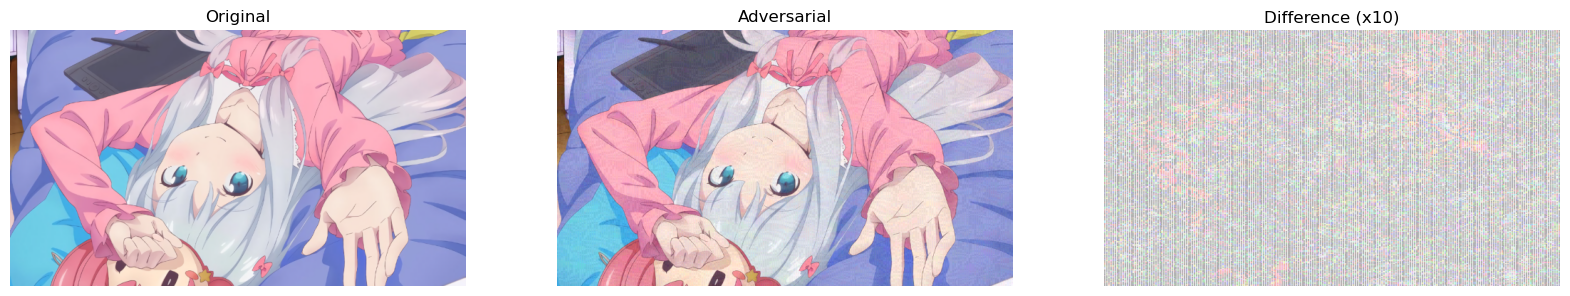

In [6]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Original", "Adversarial", "Difference (x10)"]
imgs = [img_original, np.array(tensor_to_img(x)), ~delta_img * 10]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()

# PGD

In [7]:
n_iterations = 2000
eps = 7. / 255.
bs = 32 # not needed
alpha = .1

iters_since_improvement = 0
max_iters_since_improvement = 100
best_loss = float('inf')

x = img_original_tensor.clone().detach().requires_grad_(True)

loss_func = nn.BCEWithLogitsLoss()

def forward(x):
    x = resize(x)
    x = normalize(x)
    x = model(x)
    return x

for iteration in range(n_iterations):
    model.zero_grad() # this is the fix for the author's mistake

    logits = forward(torch.cat([x] * bs, dim=0)) # bs not needed
    loss = loss_func(logits, torch.ones_like(logits)) # maximize the output of the model

    grad = torch.autograd.grad(loss, x)[0]
    x.data = x.data - alpha * torch.sign(grad)

    x.data = torch.clamp(x.data, img_original_tensor - eps, img_original_tensor + eps)

    if loss.item() < best_loss - 0.05:
        best_loss = loss.item()
        iters_since_improvement = 0
    else:
        iters_since_improvement += 1
        if iters_since_improvement >= max_iters_since_improvement:
            alpha /= 1.5
            iters_since_improvement = 0
            print(f"Reducing alpha to {alpha}")

    if iteration % (n_iterations // 20) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(current_img.astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        print(
            f"Iter: {iteration: <4} | Loss: {loss.item(): .4f} | Pred: {torch.sigmoid(torch.mean(logits)).item(): .4f} |",
            f"min/mean/max diff: {min_d:.2f}/{mean_d:.2f}/{max_d:.2f}"
        )

Iter: 0    | Loss:  2.0104 | Pred:  0.1339 | min/mean/max diff: 0.00/4.80/8.00
Iter: 100  | Loss:  2.0053 | Pred:  0.1346 | min/mean/max diff: 0.00/4.80/8.00
Reducing alpha to 0.06666666666666667
Iter: 200  | Loss:  1.9217 | Pred:  0.1464 | min/mean/max diff: 0.00/4.79/8.00
Reducing alpha to 0.044444444444444446
Iter: 300  | Loss:  1.8906 | Pred:  0.1510 | min/mean/max diff: 0.00/4.23/8.00
Reducing alpha to 0.02962962962962963
Iter: 400  | Loss:  1.8724 | Pred:  0.1538 | min/mean/max diff: 0.00/3.31/7.00
Iter: 500  | Loss:  1.5570 | Pred:  0.2108 | min/mean/max diff: 0.00/3.32/8.00
Reducing alpha to 0.019753086419753086
Iter: 600  | Loss:  1.4528 | Pred:  0.2339 | min/mean/max diff: 0.00/3.20/8.00
Iter: 700  | Loss:  1.5776 | Pred:  0.2065 | min/mean/max diff: 0.00/3.20/8.00
Reducing alpha to 0.01316872427983539
Iter: 800  | Loss:  1.2085 | Pred:  0.2986 | min/mean/max diff: 0.00/2.97/8.00
Reducing alpha to 0.008779149519890261
Iter: 900  | Loss:  0.9222 | Pred:  0.3976 | min/mean/max 

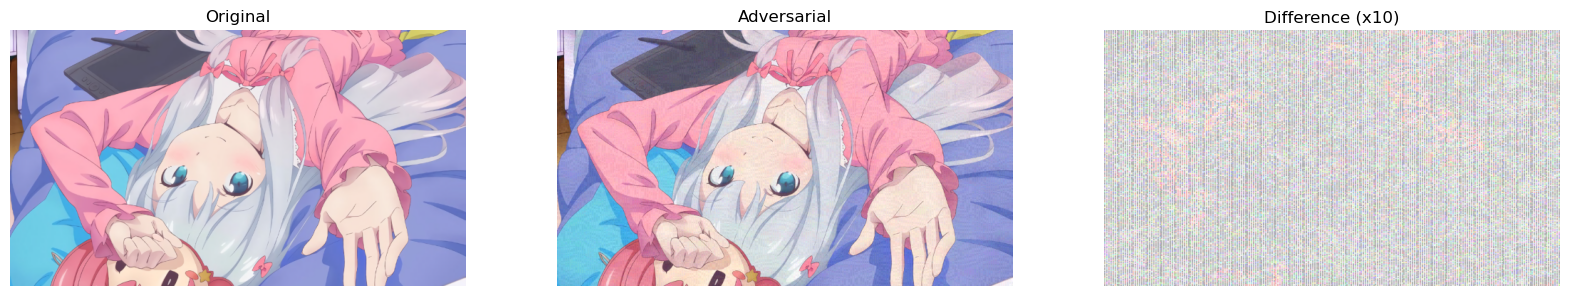

In [8]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Original", "Adversarial", "Difference (x10)"]
imgs = [img_original, np.array(tensor_to_img(x)), ~delta_img * 10]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()